In [1]:
from qiskit import QuantumCircuit, ClassicalRegister
from qiskit.transpiler import CouplingMap
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer.noise import NoiseModel, pauli_error, depolarizing_error

from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector, random_statevector

from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2
from qiskit_ibm_runtime.noise_learner import NoiseLearner
from qiskit_ibm_runtime.options import (
    NoiseLearnerOptions,
    ResilienceOptionsV2,
    EstimatorOptions,
)
import matplotlib.pyplot as plt
import numpy as np
import random
from cmath import exp
from math import atan2




# Build Noise Model

In [3]:
from qiskit_aer.noise import NoiseModel, depolarizing_error

# Create a blank noise model
noise_model = NoiseModel()

# Create a depolarizing error with 5% chance for single-qubit gates
error = depolarizing_error(0.05, 1)

# Add this error to all single-qubit gates (u1, u2, u3)
noise_model.add_all_qubit_quantum_error(error, ["u1", "u2", "u3"])

# Print the noise model to see what we added
print(noise_model)

# Imigrating to Backend  
service = QiskitRuntimeService()
backend = service.backend("ibm_torino")
noise_model = NoiseModel.from_backend(backend)


NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u3', 'u2', 'u1']
  All-qubits errors: ['u1', 'u2', 'u3']


## Quantum One-Time Pad function 

In [4]:
# QOTP Encryption: Apply X if key a[i]=1 and Z if key b[i]=1.
def qotp_encrypt(circuit, a, b, num_logical_qubits):
    for i in range(num_logical_qubits):
        physical_qubits = list(range(i * 9, (i + 1) * 9))
        if a[i]:
            for q in physical_qubits:
                circuit.x(q)
        if b[i]:
            for q in physical_qubits:
                circuit.z(q)
    return circuit

# QOTP Decryption: Apply the inverse correction.
def qotp_decrypt(circuit, a_updated, b_updated, num_logical_qubits):
    print("Starting decryption process...")
    for i in range(num_logical_qubits):
        physical_qubits = list(range(i * 9, (i + 1) * 9))
        # Apply Z correction first (undo phase flip)
        if b_updated[i]:
            for q in physical_qubits:
                circuit.z(q)
        # Apply X correction second (undo bit flip)
        if a_updated[i]:
            for q in physical_qubits:
                circuit.x(q)
    return circuit

## Homomorphic Evaluation

In [5]:
# Apply user-defined Clifford operations and update QOTP keys
def apply_user_circuit(circuit, a, b, operations):
    """Apply user-defined quantum operations and update QOTP keys.
    Returns the updated circuit and the updated keys a' and b'."""
    # Make a copy of a and b to track updates
    a_updated = a.copy()
    b_updated = b.copy()
    
    # Debug: Print initial statevector
    statevector = Statevector.from_instruction(circuit)
    print(f"Initial statevector: {statevector}")

    # Helper function for single-qubit gates
    def update_keys_for_single_qubit_gate(gate, qubit):
        nonlocal statevector
        if gate == "H":  # Hadamard gate: swap keys
            a_updated[qubit], b_updated[qubit] = b_updated[qubit], a_updated[qubit]
            circuit.h(qubit)
        elif gate == "X":  # X gate: flip b key
            b_updated[qubit] ^= 1
            circuit.x(qubit)
        elif gate == "Z":  # Z gate: flip a key
            a_updated[qubit] ^= 1
            circuit.z(qubit)
        print(f"Updated keys after {gate}({qubit}): a'={a_updated}, b'={b_updated}")
        statevector = Statevector.from_instruction(circuit)

    def update_keys_for_cnot(control, target):
        """Update QOTP keys for a CNOT gate."""
        nonlocal statevector
        b_updated[control] ^= b_updated[target]  # Update control qubit's Z correction
        a_updated[target] ^= a_updated[control]    # Update target qubit's X correction
        circuit.cx(control, target)
        print(f"Updated keys after CNOT({control}, {target}): a'={a_updated}, b'={b_updated}")
        statevector = Statevector.from_instruction(circuit)

    def apply_clifford_operations(circuit, operations):
        """Apply user-defined Clifford operations dynamically."""
        for op in operations: 
            gate = op[0]
            qubits = op[1]
            # Single-qubit gates
            if gate in {"H", "X", "Z"}:
                qubit = qubits  # single-qubit gate has one target qubit
                update_keys_for_single_qubit_gate(gate, qubit)
            # Two-qubit gate: CNOT
            elif gate == "CNOT":
                control, target = qubits
                update_keys_for_cnot(control, target)
            else:
                raise ValueError(f"Unsupported gate: {gate}. Only Clifford gates (H, X, Z, CNOT) are allowed.")
        return circuit

    # Apply the operations (each gate is now applied exactly once)
    circuit = apply_clifford_operations(circuit, operations)

    return circuit, a_updated, b_updated

## Convert statevector to symbolic 

In [6]:
# Function to normalize global phase (if needed for comparisons)
def normalize_global_phase(state1, state2):
    phase = angle(state1[0]) - angle(state2[0])
    return state2 * exp(-1j * phase)

# Convert statevector to symbolic form
def convert_statevector_to_exact_symbolic_with_order(statevector, priority_order=None):
    num_qubits = int(np.log2(len(statevector)))
    basis_states = [f"|{bin(i)[2:].zfill(num_qubits)}⟩" for i in range(len(statevector))]
    
    if priority_order:
        ordered_states = [(basis_states[i], statevector[i]) for i in priority_order]
    else:
        ordered_states = zip(basis_states, statevector)
    
    symbolic_terms = []
    for state, amp in ordered_states:
        if not np.isclose(amp, 0):
            magnitude = abs(amp)
            if np.isclose(magnitude, 1 / np.sqrt(2)):
                formatted_amp = "1/√2"
            elif np.isclose(magnitude, 1.0):
                formatted_amp = "1"
            else:
                formatted_amp = f"{magnitude:.3f}"
            if amp.real < 0:
                formatted_amp = f"-{formatted_amp}"
            symbolic_terms.append(f"{formatted_amp}{state}")
    
    return " + ".join(symbolic_terms)

## Shor's 9 codes 

In [7]:
# Shor code functions
def shor_encode(qc, physical_qubits):
    """Encode a logical qubit into 9 physical qubits using Shor code."""
    qc.h(physical_qubits[0])
    qc.h(physical_qubits[3])
    qc.h(physical_qubits[6])
    qc.cx(physical_qubits[0], physical_qubits[3])
    qc.cx(physical_qubits[0], physical_qubits[6])
    for i in [0, 3, 6]:
        qc.cx(physical_qubits[i], physical_qubits[i+1])
        qc.cx(physical_qubits[i], physical_qubits[i+2])
        qc.h(physical_qubits[i])
        qc.h(physical_qubits[i+1])
        qc.h(physical_qubits[i+2])
    return qc

def shor_decode(qc, physical_qubits, logical_bit):
    """Decode from 9 physical qubits back to 1 logical qubit."""
    for i in [0, 3, 6]:
        qc.h(physical_qubits[i])
        qc.h(physical_qubits[i+1])
        qc.h(physical_qubits[i+2])
        qc.cx(physical_qubits[i], physical_qubits[i+1])
        qc.cx(physical_qubits[i], physical_qubits[i+2])
    qc.cx(physical_qubits[0], physical_qubits[6])
    qc.cx(physical_qubits[0], physical_qubits[3])
    qc.h(physical_qubits[0])
    qc.h(physical_qubits[3])
    qc.h(physical_qubits[6])
    qc.measure(physical_qubits[0], logical_bit)
    return qc

def measure_bit_flip_syndrome(qc, group_qubits, ancilla_qubits, syndrome_bits):
    qc.cx(group_qubits[0], ancilla_qubits[0])
    qc.cx(group_qubits[1], ancilla_qubits[0])
    qc.cx(group_qubits[0], ancilla_qubits[1])
    qc.cx(group_qubits[2], ancilla_qubits[1])
    qc.measure(ancilla_qubits[0], syndrome_bits[0])
    qc.measure(ancilla_qubits[1], syndrome_bits[1])
    qc.reset(ancilla_qubits[0])
    qc.reset(ancilla_qubits[1])
    return qc

def measure_phase_flip_syndrome(qc, lead_qubits, ancilla_qubits, syndrome_bits):
    qc.h(ancilla_qubits[0])
    qc.h(ancilla_qubits[1])
    qc.cz(lead_qubits[0], ancilla_qubits[0])
    qc.cz(lead_qubits[1], ancilla_qubits[0])
    qc.cz(lead_qubits[0], ancilla_qubits[1])
    qc.cz(lead_qubits[2], ancilla_qubits[1])
    qc.h(ancilla_qubits[0])
    qc.h(ancilla_qubits[1])
    qc.measure(ancilla_qubits[0], syndrome_bits[0])
    qc.measure(ancilla_qubits[1], syndrome_bits[1])
    qc.reset(ancilla_qubits[0])
    qc.reset(ancilla_qubits[1])
    return qc

# Integrated Active QEC-QHE Framework with Clifford Evaluation

In [8]:
# Integrated Active QEC-QHE Framework with Clifford Evaluation
def apply_user_circuit_with_qec(circuit, a, b, operations, num_logical_qubits, noise_model, expected_states=None, 
                                qec_code=None, shots=256, batch_size=64):
    """
    Apply user-defined quantum operations with Active QEC using Shor code.
    
    Args:
        circuit: User-defined quantum circuit.
        a, b: QOTP parameters.
        operations: List of operations to apply.
        num_logical_qubits: Number of logical qubits.
        noise_model: Pre-defined noise model to use for simulation.
        expected_states: List of expected correct states. If None, compute dynamically.
        qec_code: Dict with QEC code functions and parameters.
        shots: Total number of shots (default reduced to 256).
        batch_size: Number of shots per batch (default reduced to 64).
    """
    # Default QEC code (Shor’s code with reduced ancilla)
    if qec_code is None:
        qec_code = {
            'encode': shor_encode,
            'decode': shor_decode,
            'measure_bit_flip': measure_bit_flip_syndrome,
            'measure_phase_flip': measure_phase_flip_syndrome,
            'physical_per_logical': 9,
            'ancilla_per_logical': 2  # Reduced by reusing ancilla qubits
        }

    # Qubit allocation
    num_physical_qubits = num_logical_qubits * qec_code['physical_per_logical']
    num_ancilla_qubits = num_logical_qubits * qec_code['ancilla_per_logical']
    num_syndrome_bits = num_logical_qubits * 2  # 2 syndrome bits per logical qubit per round

    # First, apply the Clifford operations on the logical qubits
    logical_circuit, a_updated, b_updated = apply_user_circuit(circuit, a, b, operations)

    # If expected_states is None, compute it using an ideal simulation
    if expected_states is None:
        # Create a copy of the logical circuit for ideal simulation
        ideal_circuit = logical_circuit.copy()
        cr_logical = ClassicalRegister(num_logical_qubits, 'logical')
        ideal_circuit.add_register(cr_logical)
        for i in range(num_logical_qubits):
            ideal_circuit.measure(i, i)
        
        # Run ideal simulation
        ideal_sim = AerSimulator()
        result_ideal = ideal_sim.run(ideal_circuit, shots=1024).result()
        ideal_counts = result_ideal.get_counts()
        
        # Take the most frequent states as expected (adjust threshold as needed)
        total_ideal_shots = sum(ideal_counts.values())
        threshold = 0.1 * total_ideal_shots  # Consider states with at least 10% of shots
        expected_states = [state for state, count in ideal_counts.items() if count >= threshold]
        print(f"Dynamically computed expected states: {expected_states}")

    # Validate expected_states
    expected_length = num_logical_qubits
    for state in expected_states:
        if not isinstance(state, str) or len(state) != expected_length or not set(state).issubset({'0', '1'}):
            raise ValueError(f"Invalid expected state '{state}'. Expected {expected_length}-bit binary string (e.g., '0' for 1 qubit).")

    # Create a new circuit with physical and ancilla qubits for syndrome measurement
    qc = QuantumCircuit(num_physical_qubits + num_ancilla_qubits)
    cr_syndrome = ClassicalRegister(num_syndrome_bits, 'syndrome')
    cr_logical = ClassicalRegister(num_logical_qubits, 'logical')
    qc.add_register(cr_syndrome)
    qc.add_register(cr_logical)

    data_qubits = list(range(num_physical_qubits))
    ancilla_qubits = list(range(num_physical_qubits, num_physical_qubits + num_ancilla_qubits))

    # Create a mapping of Qubit objects to their indices
    qubit_mapping = {qubit: idx for idx, qubit in enumerate(logical_circuit.qubits)}

    # Encode each logical qubit into physical qubits
    for i in range(num_logical_qubits):
        physical_qubits = list(range(i * qec_code['physical_per_logical'], 
                                   (i + 1) * qec_code['physical_per_logical']))
        qc = qec_code['encode'](qc, physical_qubits)

    # Re-apply the operations on the physical qubits
    for gate in logical_circuit.data:
        op = gate.operation.name
        qubits = [qubit_mapping[q] for q in gate.qubits]
        if op in ["h", "x", "z"]:
            qubit = qubits[0]
            physical_qubits = list(range(qubit * qec_code['physical_per_logical'], 
                                       (qubit + 1) * qec_code['physical_per_logical']))
            for q in physical_qubits:
                if op == "h":
                    qc.h(q)
                elif op == "x":
                    qc.x(q)
                elif op == "z":
                    qc.z(q)
        elif op == "cx":
            control, target = qubits
            control_physical = list(range(control * qec_code['physical_per_logical'], 
                                        (control + 1) * qec_code['physical_per_logical']))
            target_physical = list(range(target * qec_code['physical_per_logical'], 
                                       (target + 1) * qec_code['physical_per_logical']))
            for c, t in zip(control_physical, target_physical):
                qc.cx(c, t)

    # Encrypt the circuit using QOTP (on physical qubits)
    qc = qotp_encrypt(qc, a_updated, b_updated, num_logical_qubits)

    # Measure syndromes after all operations (multiple rounds)
    num_rounds = 3
    for _ in range(num_rounds):
        for i in range(num_logical_qubits):
            physical_qubits = list(range(i * qec_code['physical_per_logical'], 
                                       (i + 1) * qec_code['physical_per_logical']))
            ancilla_pair = ancilla_qubits[i * qec_code['ancilla_per_logical']:
                                        (i + 1) * qec_code['ancilla_per_logical']]
            syndrome_pair = [i * 2, i * 2 + 1]
            for j in [0, 3, 6]:
                group_qubits = physical_qubits[j:j+3]
                qc = qec_code['measure_bit_flip'](qc, group_qubits, ancilla_pair, syndrome_pair)
            lead_qubits = [physical_qubits[0], physical_qubits[3], physical_qubits[6]]
            qc = qec_code['measure_phase_flip'](qc, lead_qubits, ancilla_pair, syndrome_pair)

    # Create the corrected circuit before the simulation loop
    qc_corrected = QuantumCircuit(num_physical_qubits + num_ancilla_qubits)
    cr_syndrome = ClassicalRegister(num_syndrome_bits, 'syndrome')
    cr_logical = ClassicalRegister(num_logical_qubits, 'logical')
    qc_corrected.add_register(cr_syndrome)
    qc_corrected.add_register(cr_logical)

    # Re-encode
    for i in range(num_logical_qubits):
        physical_qubits = list(range(i * qec_code['physical_per_logical'], 
                                   (i + 1) * qec_code['physical_per_logical']))
        qc_corrected = qec_code['encode'](qc_corrected, physical_qubits)

    # Re-apply operations
    for gate in logical_circuit.data:
        op = gate.operation.name
        qubits = [qubit_mapping[q] for q in gate.qubits]
        if op in ["h", "x", "z"]:
            qubit = qubits[0]
            physical_qubits = list(range(qubit * qec_code['physical_per_logical'], 
                                       (qubit + 1) * qec_code['physical_per_logical']))
            for q in physical_qubits:
                if op == "h":
                    qc_corrected.h(q)
                elif op == "x":
                    qc_corrected.x(q)
                elif op == "z":
                    qc_corrected.z(q)
        elif op == "cx":
            control, target = qubits
            control_physical = list(range(control * qec_code['physical_per_logical'], 
                                        (control + 1) * qec_code['physical_per_logical']))
            target_physical = list(range(target * qec_code['physical_per_logical'], 
                                       (target + 1) * qec_code['physical_per_logical']))
            for c, t in zip(control_physical, target_physical):
                qc_corrected.cx(c, t)

    # Apply QOTP decryption
    qc_corrected = qotp_decrypt(qc_corrected, a_updated, b_updated, num_logical_qubits)

    # Run the circuit to get syndrome measurements using the provided noise model
    sim_noise = AerSimulator(noise_model=noise_model, method='matrix_product_state', 
                             matrix_product_state_max_bond_dimension=16)
    num_batches = (shots + batch_size - 1) // batch_size
    corrected_counts = {}

    for batch in range(num_batches):
        current_batch_size = min(batch_size, shots - batch * batch_size)
        result_shor = sim_noise.run(qc, shots=current_batch_size, memory=True).result()
        memory = result_shor.get_memory()

        for shot in memory:
            syndrome_part = shot.split()[0]
            logical_part = shot.split()[1]
            qc_shot = qc_corrected.copy()

            for i in range(num_logical_qubits):
                physical_qubits = list(range(i * qec_code['physical_per_logical'], 
                                           (i + 1) * qec_code['physical_per_logical']))
                syndrome_start = i * 2
                if syndrome_start + 1 < len(syndrome_part):
                    s0 = int(syndrome_part[syndrome_start])
                    s1 = int(syndrome_part[syndrome_start + 1])
                    for j in [0, 3, 6]:
                        if s0 == 1 and s1 == 1:
                            qc_shot.x(physical_qubits[j])
                        elif s0 == 1 and s1 == 0:
                            qc_shot.x(physical_qubits[j + 2])
                        elif s0 == 0 and s1 == 1:
                            qc_shot.x(physical_qubits[j + 1])
                syndrome_start += 2
                if syndrome_start + 1 < len(syndrome_part):
                    s0 = int(syndrome_part[syndrome_start])
                    s1 = int(syndrome_part[syndrome_start + 1])
                    if s0 == 1 and s1 == 1:
                        for j in range(3):
                            qc_shot.z(physical_qubits[j])
                    elif s0 == 1 and s1 == 0:
                        for j in range(6, 9):
                            qc_shot.z(physical_qubits[j])
                    elif s0 == 0 and s1 == 1:
                        for j in range(3, 6):
                            qc_shot.z(physical_qubits[j])

            for i in range(num_logical_qubits):
                physical_qubits = list(range(i * qec_code['physical_per_logical'], 
                                           (i + 1) * qec_code['physical_per_logical']))
                qc_shot = qec_code['decode'](qc_shot, physical_qubits, i)

            result_shot = sim_noise.run(qc_shot, shots=1).result()
            counts_shot = result_shot.get_counts()
            state = list(counts_shot.keys())[0]
            corrected_counts[state] = corrected_counts.get(state, 0) + 1

    counts_noise_with_qec = corrected_counts
    print("\nCounts with Shor Code (with classical correction):", counts_noise_with_qec)

    # Calculate the error rate (only consider logical part)
    total_shots = shots
    incorrect_counts_shor = sum(count for state, count in counts_noise_with_qec.items() 
                               if state.split()[0] not in expected_states)
    error_rate_shor = incorrect_counts_shor / total_shots

    # Plot the histogram
    threshold = 0
    filtered_counts = {state: count for state, count in counts_noise_with_qec.items() if count > threshold}
    sorted_counts = dict(sorted(filtered_counts.items(), key=lambda x: x[1], reverse=True))

    fig, ax = plt.subplots(figsize=(10, 6))
    plot_histogram(
        sorted_counts,
        ax=ax,
        title=f"Noisy with Shor Code (Active QEC)\nError Rate: {error_rate_shor:.3f}",
        color='skyblue'
    )

    for patch in ax.patches:
        current_width = patch.get_width()
        patch.set_width(current_width * 1.5)
        patch.set_x(patch.get_x() - (patch.get_width() - current_width) / 2)
        patch.set_edgecolor('black')

    for i, (state, count) in enumerate(sorted_counts.items()):
        ax.text(i, count + 5, str(count), ha='center', va='bottom', fontsize=10, fontweight='bold')

    ax.set_xlabel('States', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_title(f"Noisy with Shor Code (Active QEC)\nError Rate: {error_rate_shor:.3f}", fontsize=14, pad=20)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.tick_params(axis='x', rotation=45, labelsize=10)
    ax.tick_params(axis='y', labelsize=10)

    plt.tight_layout()
    plt.show()

    return qc_corrected, a_updated, b_updated, logical_circuit


Random QOTP Keys:
X keys (a): [0]
Z keys (b): [0]

Plaintext (initial) state vector:
Statevector([1.+0.j, 0.+0.j],
            dims=(2,))
Initial statevector: Statevector([1.+0.j, 0.+0.j],
            dims=(2,))
Updated keys after H(0): a'=[0], b'=[0]
Updated keys after X(0): a'=[0], b'=[1]
Updated keys after H(0): a'=[1], b'=[0]
Dynamically computed expected states: ['0']
Starting decryption process...

Counts with Shor Code (with classical correction): {'0 01': 212, '0 00': 44}


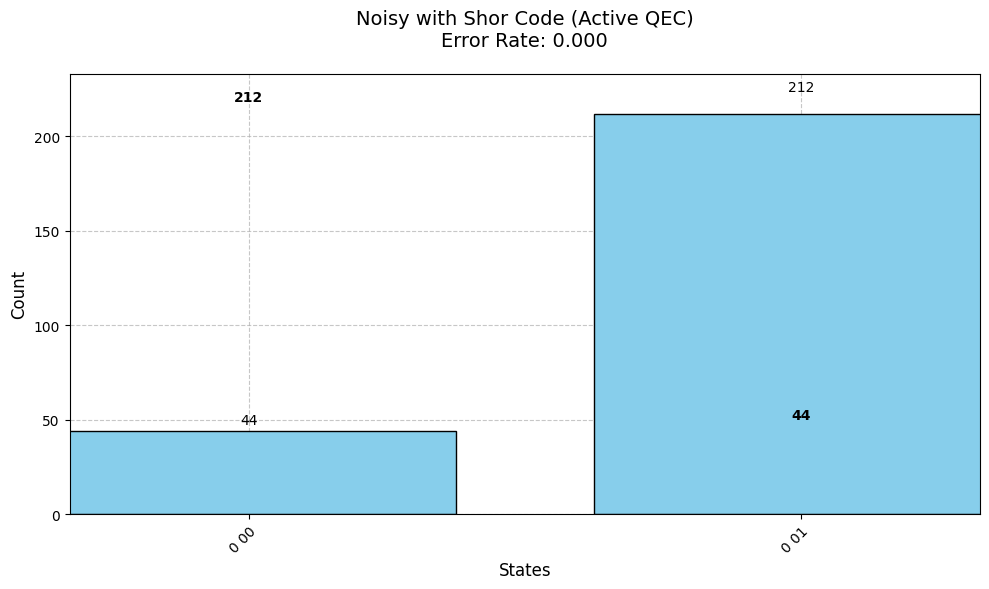

Starting decryption process...

Quantum Circuit After QOTP Decryption:
            ┌───┐                    ┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐
       q_0: ┤ H ├──■────■────■────■──┤ H ├┤ H ├┤ X ├┤ H ├┤ X ├┤ X ├
            └───┘  │    │  ┌─┴─┐  │  ├───┤├───┤├───┤├───┤├───┤├───┤
       q_1: ───────┼────┼──┤ X ├──┼──┤ H ├┤ H ├┤ X ├┤ H ├┤ X ├┤ X ├
                   │    │  └───┘┌─┴─┐├───┤├───┤├───┤├───┤├───┤├───┤
       q_2: ───────┼────┼───────┤ X ├┤ H ├┤ H ├┤ X ├┤ H ├┤ X ├┤ X ├
            ┌───┐┌─┴─┐  │       └───┘├───┤├───┤├───┤├───┤├───┤├───┤
       q_3: ┤ H ├┤ X ├──┼────■────■──┤ H ├┤ H ├┤ X ├┤ H ├┤ X ├┤ X ├
            └───┘└───┘  │  ┌─┴─┐  │  ├───┤├───┤├───┤├───┤├───┤├───┤
       q_4: ────────────┼──┤ X ├──┼──┤ H ├┤ H ├┤ X ├┤ H ├┤ X ├┤ X ├
                        │  └───┘┌─┴─┐├───┤├───┤├───┤├───┤├───┤├───┤
       q_5: ────────────┼───────┤ X ├┤ H ├┤ H ├┤ X ├┤ H ├┤ X ├┤ X ├
            ┌───┐     ┌─┴─┐     └───┘├───┤├───┤├───┤├───┤├───┤├───┤
       q_6: ┤ H ├─────┤ X ├──■────■──┤ H ├┤ H

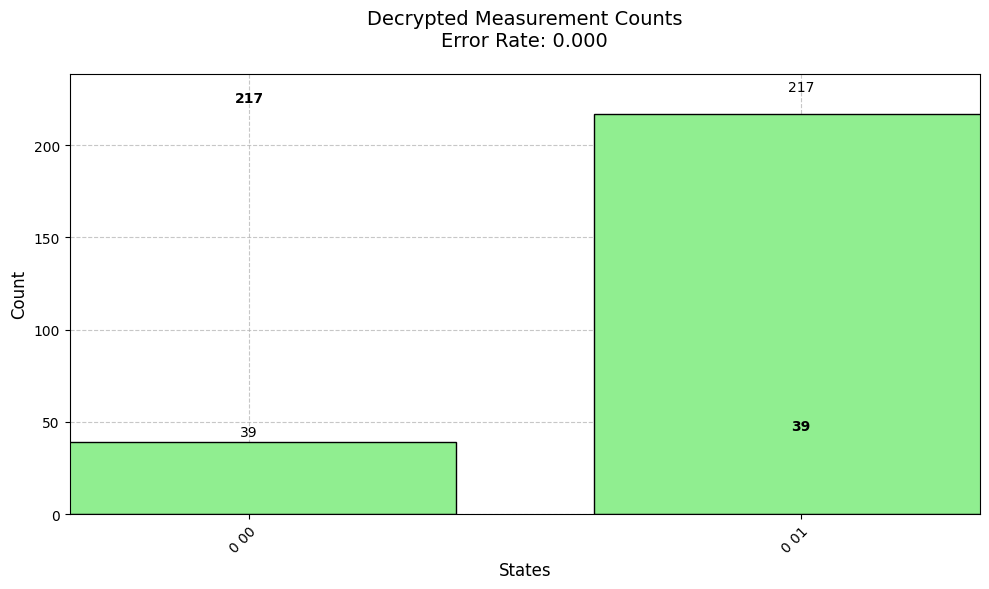

In [9]:
# Example usage
operations = [
    ("H", 0),
    ("X", 0),
    ("H", 0),
]

num_qubits = 1  # Reduced to 1 to fit within 32 GB memory
a = [random.randint(0, 1) for _ in range(num_qubits)]
b = [random.randint(0, 1) for _ in range(num_qubits)]
print("\nRandom QOTP Keys:")
print(f"X keys (a): {a}")
print(f"Z keys (b): {b}")

# Define the initial circuit
qc = QuantumCircuit(num_qubits)
initial_statevector = Statevector.from_instruction(qc)
print("\nPlaintext (initial) state vector:")
print(initial_statevector)

# Define the QEC code (Shor’s code with reduced ancilla)
qec_code = {
    'encode': shor_encode,
    'decode': shor_decode,
    'measure_bit_flip': measure_bit_flip_syndrome,
    'measure_phase_flip': measure_phase_flip_syndrome,
    'physical_per_logical': 9,
    'ancilla_per_logical': 2  # Reduced by reusing ancilla qubits
}

# Apply QEC and homomorphic evaluation
# Pass the noise_model (already defined earlier)
qc_evaluated, a_updated, b_updated, logical_circuit = apply_user_circuit_with_qec(
    qc, a, b, operations, num_qubits, noise_model, expected_states=None, qec_code=qec_code
)

# Decrypt the evaluated circuit
qc_decrypted = qotp_decrypt(qc_evaluated.copy(), a_updated, b_updated, num_qubits)
print("\nQuantum Circuit After QOTP Decryption:")
print(qc_decrypted)

# Reapply syndrome measurement and correction after decryption
num_physical_qubits = num_qubits * qec_code['physical_per_logical']
num_ancilla_qubits = num_qubits * qec_code['ancilla_per_logical']
num_syndrome_bits = num_qubits * 2
ancilla_qubits = list(range(num_physical_qubits, num_physical_qubits + num_ancilla_qubits))
for i in range(num_qubits):
    physical_qubits = list(range(i * qec_code['physical_per_logical'], (i + 1) * qec_code['physical_per_logical']))
    ancilla_pair = ancilla_qubits[i * qec_code['ancilla_per_logical']:(i + 1) * qec_code['ancilla_per_logical']]
    syndrome_pair = [i * 2, i * 2 + 1]
    for j in [0, 3, 6]:
        group_qubits = physical_qubits[j:j+3]
        qc_decrypted = qec_code['measure_bit_flip'](qc_decrypted, group_qubits, ancilla_pair, syndrome_pair)
    lead_qubits = [physical_qubits[0], physical_qubits[3], physical_qubits[6]]
    qc_decrypted = qec_code['measure_phase_flip'](qc_decrypted, lead_qubits, ancilla_pair, syndrome_pair)

# Create qc_final before the simulation loop
qc_final = QuantumCircuit(num_physical_qubits + num_ancilla_qubits)
cr_syndrome = ClassicalRegister(num_syndrome_bits, 'syndrome')
cr_logical = ClassicalRegister(num_qubits, 'logical')
qc_final.add_register(cr_syndrome)
qc_final.add_register(cr_logical)

# Re-encode
for i in range(num_qubits):
    physical_qubits = list(range(i * qec_code['physical_per_logical'], (i + 1) * qec_code['physical_per_logical']))
    qc_final = qec_code['encode'](qc_final, physical_qubits)

# Redefine qubit_mapping using logical_circuit
qubit_mapping = {qubit: idx for idx, qubit in enumerate(logical_circuit.qubits)}

# Re-apply operations
for gate in logical_circuit.data:
    op = gate.operation.name
    qubits = [qubit_mapping[q] for q in gate.qubits]
    if op in ["h", "x", "z"]:
        qubit = qubits[0]
        physical_qubits = list(range(qubit * qec_code['physical_per_logical'], (qubit + 1) * qec_code['physical_per_logical']))
        for q in physical_qubits:
            if op == "h":
                qc_final.h(q)
            elif op == "x":
                qc_final.x(q)
            elif op == "z":
                qc_final.z(q)
    elif op == "cx":
        control, target = qubits
        control_physical = list(range(control * qec_code['physical_per_logical'], (control + 1) * qec_code['physical_per_logical']))
        target_physical = list(range(target * qec_code['physical_per_logical'], (target + 1) * qec_code['physical_per_logical']))
        for c, t in zip(control_physical, target_physical):
            qc_final.cx(c, t)

# Apply QOTP decryption
qc_final = qotp_decrypt(qc_final, a_updated, b_updated, num_qubits)

# Run the circuit to get syndrome measurements after decryption
sim_noise = AerSimulator(noise_model=noise_model, method='matrix_product_state', 
                         matrix_product_state_max_bond_dimension=16)
shots = 256
batch_size = 64
num_batches = (shots + batch_size - 1) // batch_size
final_counts = {}

# Compute expected states dynamically (same as in apply_user_circuit_with_qec)
ideal_circuit = logical_circuit.copy()
cr_logical = ClassicalRegister(num_qubits, 'logical')
ideal_circuit.add_register(cr_logical)
for i in range(num_qubits):
    ideal_circuit.measure(i, i)
ideal_sim = AerSimulator()
result_ideal = ideal_sim.run(ideal_circuit, shots=1024).result()
ideal_counts = result_ideal.get_counts()
total_ideal_shots = sum(ideal_counts.values())
threshold = 0.1 * total_ideal_shots
expected_states = [state for state, count in ideal_counts.items() if count >= threshold]
print(f"Dynamically computed expected states for decrypted circuit: {expected_states}")

# Validate expected_states
expected_length = num_qubits
for state in expected_states:
    if not isinstance(state, str) or len(state) != expected_length or not set(state).issubset({'0', '1'}):
        raise ValueError(f"Invalid expected state '{state}'. Expected {expected_length}-bit binary string (e.g., '0' for 1 qubit).")

# Process shots in batches
for batch in range(num_batches):
    current_batch_size = min(batch_size, shots - batch * batch_size)
    result_decrypted = sim_noise.run(qc_decrypted, shots=current_batch_size, memory=True).result()
    memory = result_decrypted.get_memory()

    for shot in memory:
        syndrome_part = shot.split()[0]
        logical_part = shot.split()[1]
        qc_shot = qc_final.copy()

        for i in range(num_qubits):
            physical_qubits = list(range(i * qec_code['physical_per_logical'], (i + 1) * qec_code['physical_per_logical']))
            syndrome_start = i * 2
            if syndrome_start + 1 < len(syndrome_part):
                s0 = int(syndrome_part[syndrome_start])
                s1 = int(syndrome_part[syndrome_start + 1])
                for j in [0, 3, 6]:
                    if s0 == 1 and s1 == 1:
                        qc_shot.x(physical_qubits[j])
                    elif s0 == 1 and s1 == 0:
                        qc_shot.x(physical_qubits[j + 2])
                    elif s0 == 0 and s1 == 1:
                        qc_shot.x(physical_qubits[j + 1])
            syndrome_start += 2
            if syndrome_start + 1 < len(syndrome_part):
                s0 = int(syndrome_part[syndrome_start])
                s1 = int(syndrome_part[syndrome_start + 1])
                if s0 == 1 and s1 == 1:
                    for j in range(3):
                        qc_shot.z(physical_qubits[j])
                elif s0 == 1 and s1 == 0:
                    for j in range(6, 9):
                        qc_shot.z(physical_qubits[j])
                elif s0 == 0 and s1 == 1:
                    for j in range(3, 6):
                        qc_shot.z(physical_qubits[j])

        for i in range(num_qubits):
            physical_qubits = list(range(i * qec_code['physical_per_logical'], (i + 1) * qec_code['physical_per_logical']))
            qc_shot = qec_code['decode'](qc_shot, physical_qubits, i)

        result_shot = sim_noise.run(qc_shot, shots=1).result()
        counts_shot = result_shot.get_counts()
        state = list(counts_shot.keys())[0]
        final_counts[state] = final_counts.get(state, 0) + 1

# Calculate error rate
total_shots = shots
incorrect_counts = sum(count for state, count in final_counts.items() if state.split()[0] not in expected_states)
error_rate = incorrect_counts / total_shots

# Print and plot the final counts
print("\nDecrypted measurement counts:")
print(final_counts)
print(f"Error rate: {error_rate:.3f}")

fig, ax = plt.subplots(figsize=(10, 6))
plot_histogram(
    final_counts,
    ax=ax,
    title=f"Decrypted Measurement Counts\nError Rate: {error_rate:.3f}",
    color='lightgreen'
)

for patch in ax.patches:
    current_width = patch.get_width()
    patch.set_width(current_width * 1.5)
    patch.set_x(patch.get_x() - (patch.get_width() - current_width) / 2)
    patch.set_edgecolor('black')

for i, (state, count) in enumerate(final_counts.items()):
    ax.text(i, count + 5, str(count), ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_xlabel('States', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title(f"Decrypted Measurement Counts\nError Rate: {error_rate:.3f}", fontsize=14, pad=20)
ax.grid(True, linestyle='--', alpha=0.7)
ax.tick_params(axis='x', rotation=45, labelsize=10)
ax.tick_params(axis='y', labelsize=10)

plt.tight_layout()
plt.show()